In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import shutil
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
import random
from tqdm.notebook import tqdm
import warnings
from torch.autograd import Variable
from IPython.display import clear_output
import numpy as np
import itertools
import time
import datetime
from torchvision.utils import save_image
import matplotlib.image as mpimg
from PIL import Image
import torchvision.transforms as transforms

In [6]:
class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


hp = Hyperparameters(
    epoch=0,
    n_epochs=40,
    dataset_train_mode="train",
    dataset_test_mode="test",
    batch_size=5,
    lr=0.0002,
    decay_start_epoch=1,
    b1=0.5,
    b2=0.999,
    n_cpu=4,
    img_size=256,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=9,
    lambda_cyc=10.0,
    lambda_id=5.0,
    img_height = 128,
    img_width = 128,
)

# Loading Dataset

In [7]:
root = '/kaggle/input/gan-getting-started/'
print(root)
print(os.listdir(root))
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'

/kaggle/input/gan-getting-started/
['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


In [8]:
def convert_to_rgb(image):
    """
    Convert an image to RGB format.

    Args:
        image (PIL.Image.Image): Input image.

    Returns:
        PIL.Image.Image: RGB converted image.

    """
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

    
transforms_ = [
    transforms.Resize(int(hp.img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((hp.img_height, hp.img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]


class MonetPhotoDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+photo_path)+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+monet_path)+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+photo_path)+'/*.*')[250:301])
            self.files_B = sorted(glob.glob(os.path.join(root+monet_path)+'/*.*')[:250])

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        # a % b => a is divided by b, and the remainder of that division is returned.

        if self.unaligned:
            #image is selected randomly
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]) 
        else:
            #image is selected deterministicly
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)

        # Finally return a dict
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [9]:
dataloader = DataLoader(
    MonetPhotoDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=hp.batch_size, 
    shuffle=True,
    num_workers=hp.n_cpu 
)

val_dataloader = DataLoader(
    MonetPhotoDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=hp.n_cpu
)

* The PyTorch module `nn.ReflectionPad2d` pads the input tensor with mirrored border values, preserving edge information, which is useful for image segmentation and classification tasks.
* `InstanceNorm2d` in PyTorch normalizes each instance in a batch independently, which is useful for style transfer and other image processing tasks.

# Generator
- The generator consists of encoder and decoder. It downsamples or encode the input image, them interpret the encoding with 9 Residual Blocks having skip connections. After that witha a series of layers it upsample or decode the representation to the size of the fake image.
- Reflection padding "reflects" the row into the padding. It is used mostly for brightness, contrast and for reducing artifact.
- Instance Norm normalizes each batch independently and across spatial locations only.

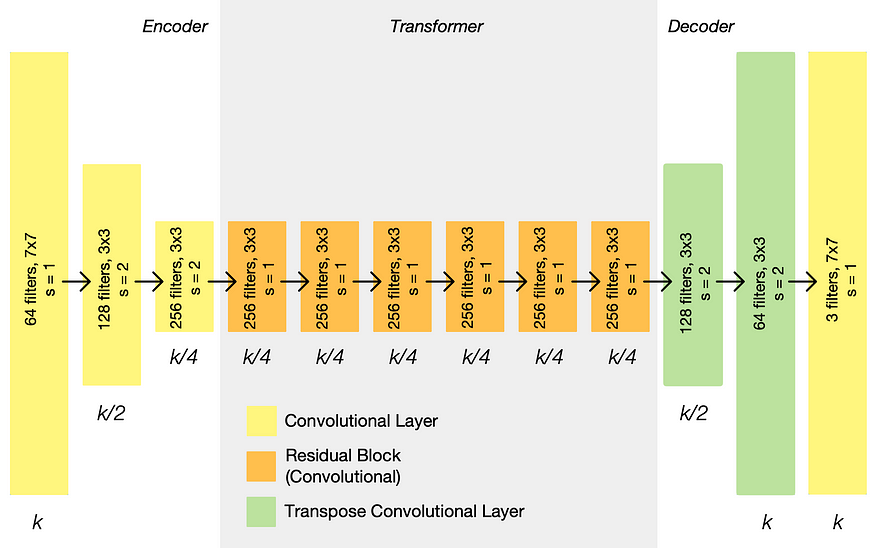

In [10]:
# Residual block with two convolution layers.
class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),  # Reflection padding is used because it gives better image quality at edges.
            nn.Conv2d(in_channel, in_channel, 3),  # Paper says - same number of filters on both layer.
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

# Generator
""" As per Paper -- Generator with 9 residual blocks consists of:
c7s1-64,d128,d256,R256,R256,R256, R256,R256,R256,R256,R256,R256,
u128, u64,c7s1-3
 """


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64
        # I define a variable 'model' which I will continue to update
        # throughout the 3 blocks of Residual -> Downsampling -> Upsampling
        # First c7s1-64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, kernel_size=7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=3, stride=2, padding=1
                ),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        """ Residual blocks - Per Paper
        R256,R256,R256,R256,R256,R256,R256,R256,R256
        """
        # Residual Blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=3, stride=1, padding=1
                ),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        # c7s1-3
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

The input and output shapes need to be the same for the GeneratorResNet model because it ensures that the generated images have the same dimensions as the input images, which is crucial for tasks like image-to-image translation where you want to maintain the original image size.

In [ ]:
def test_generator_resnet(input_shape, num_residual_blocks):
    # Create a dummy input tensor with the defined shape
    input_tensor = torch.randn(1, *input_shape)  # Batch size of 1

    # Initialize the GeneratorResNet model
    generator = GeneratorResNet(input_shape, num_residual_blocks)

    # Print the model architecture
    print(generator)

    # Forward pass the input tensor through the generator
    output_tensor = generator(input_tensor)

    # Print the input and output shapes
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output_tensor.shape}")

    # Check if the input and output shapes are the same
    assert input_tensor.shape == output_tensor.shape, "Output shape does not match input shape!"

    print("Test passed! The output shape matches the input shape.")

In [ ]:
input_shape = (hp.channels, hp.img_height, hp.img_width) # (3,256,256)
num_residual_blocks = 9
test_generator_resnet(input_shape, num_residual_blocks)

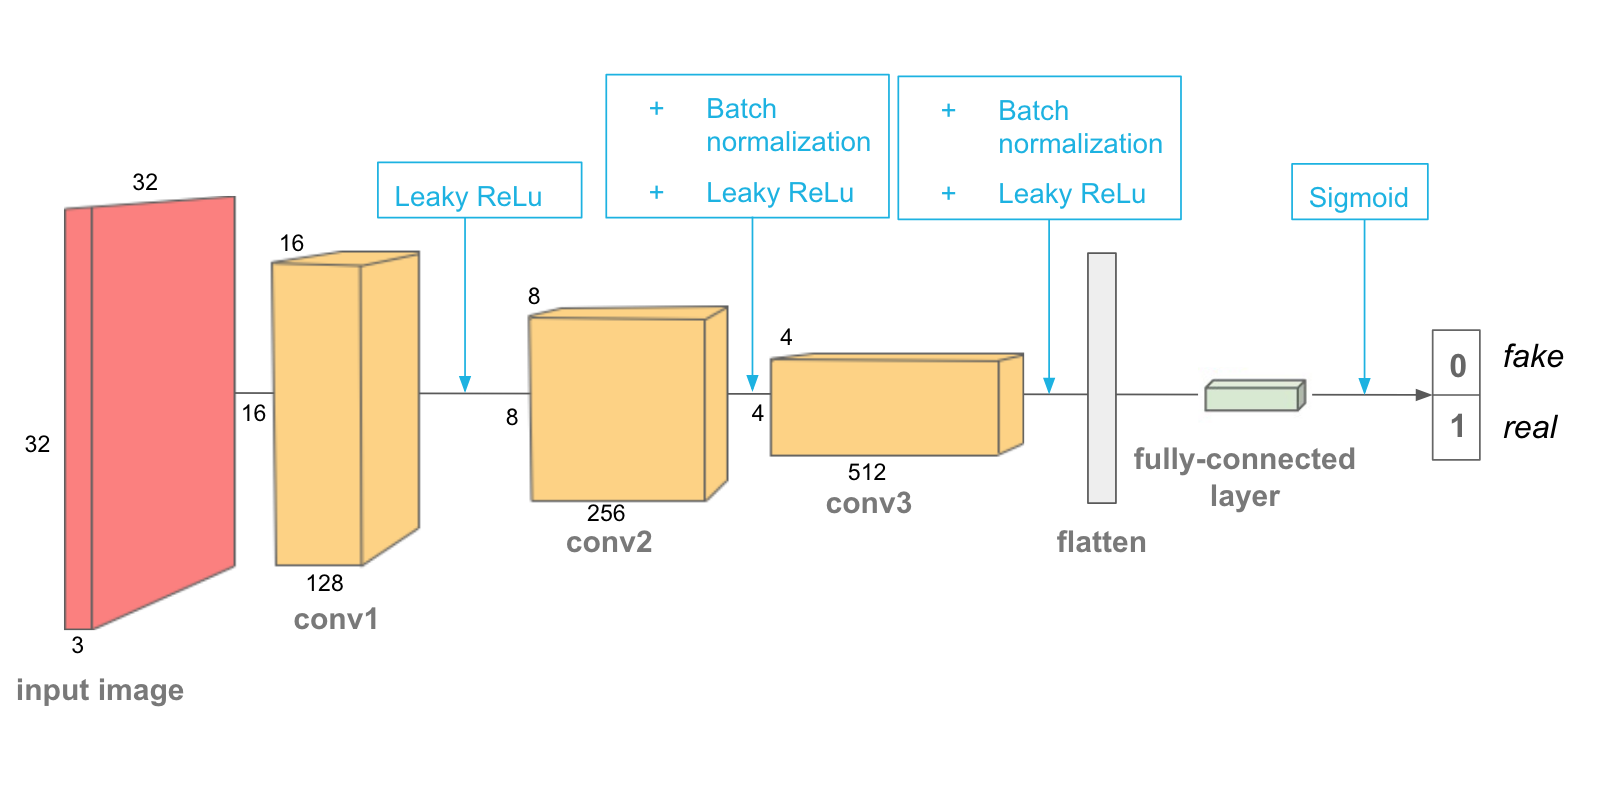

In [ ]:
##############################
#        Discriminator
##############################
""" We use 70 × 70 PatchGAN.

Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2.

After the last layer, we apply a convolution to produce a 1-dimensional output.

We do not use InstanceNorm for the first C64 layer.

We use leaky ReLUs with a slope of 0.2. The discriminator architecture is:" C64-C128-C256-C512 """


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
            ]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
def test_discriminator(input_shape):
    try:
        # Create a dummy input tensor with the defined shape
        input_tensor = torch.randn(1, *input_shape)  # Batch size of 1

        # Initialize the Discriminator model
        discriminator = Discriminator(input_shape)

        # Print the model architecture
        print(discriminator)

        # Forward pass the input tensor through the discriminator
        output_tensor = discriminator(input_tensor)

        # Print the input and output shapes
        print(f"Input shape: {input_tensor.shape}")
        print(f"Output shape: {output_tensor.shape}")

        # Check if the output shape is as expected
        expected_output_shape = discriminator.output_shape
        assert output_tensor.shape[1:] == expected_output_shape, f"Output shape {output_tensor.shape[1:]} does not match expected shape {expected_output_shape}!"

        print("Test passed! The output shape matches the expected shape.")
    except Exception as e:
        print(f"Test failed: {e}")

In [ ]:
input_shape = (3, 256, 256)
test_discriminator(input_shape)

In [ ]:
class ReplayBuffer:
    """
    A class used to represent a Replay Buffer. This buffer stores a certain number of previously
    generated images for training a Generative Adversarial Network (CycleGAN).
    This ReplayBuffer class is a useful tool in the context of CycleGAN as it can help
    to stabilize the learning process by reusing older generated images.

    ...

    Attributes
    ----------
    max_size : int
        maximum number of images that can be stored in the buffer
    data : list
        the list storing the images

    Methods
    -------
    push_and_pop(data):
        Adds new images to the buffer and returns a mixed batch of old and new images.
    """

    # We keep an image buffer that stores
    # the 50 previously created images.
    def __init__(self, max_size=50):
        """
        Constructs the necessary attributes for the ReplayBuffer object.

        Parameters
        ----------
            max_size : int
                maximum number of images that can be stored in the buffer. Should be greater than 0.
        """
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        """
        This method accepts a batch of images, saves them to the buffer, and returns a new batch of images.
        The returned batch is composed of some of the new images and, when the buffer is full, possibly some older images.

        Parameters
        ----------
            data : torch.Tensor
                The new images to add to the buffer.

        Returns
        -------
            torch.Tensor
                A batch of images consisting of new images and possibly some older images from the buffer.
        """
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                '''
                If the buffer is full, decide whether to replace an old image in the buffer with the new one,
                and whether to add the new image or an old image to the return batch.
                '''

                if random.uniform(0, 1) > 0.5:
                    # With a 50% chance, replace an old image in the buffer with the new image
                    # and add the old image to the return batch.
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # With a 50% chance, keep the buffer as is and add the new image to the return batch.
                    to_return.append(element)
        return Variable(torch.cat(to_return))

The reason for doing "np.transpose(npimg, (1, 2, 0))"

PyTorch modules processing image data expect tensors in the format C × H × W.
Whereas PILLow and Matplotlib expect image arrays in the format H × W × C
so to use them with matplotlib you need to reshape it
to put the channels as the last dimension:

I could have used permute() method as well like below
plt.imshow(pytorch_tensor_image.permute(1, 2, 0))

# Image viz
The reason for doing "np.transpose(npimg, (1, 2, 0))"

PyTorch modules processing image data expect tensors in the format C × H × W.
Whereas PILLow and Matplotlib expect image arrays in the format H × W × C
so to use them with matplotlib you need to reshape it
to put the channels as the last dimension:

I could have used permute() method as well like below
plt.imshow(pytorch_tensor_image.permute(1, 2, 0))


In [ ]:
def show_img(img, size=10):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(size, size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
data_iter = iter(val_dataloader)
batch = next(data_iter)
img = batch['A'][0]  

# Use the show_img function to display the image
show_img(img)

# LOSS

In [ ]:
# SETUP, LOSS, INITIALIZE MODELS and BUFFERS
'''
# Creating criterion object (Loss Function) that will
# measure the error between the prediction and the target.
'''
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()


# Buffers of previously generated samples
monet_buffer = ReplayBuffer()

# Initialize generator and discriminator

In [ ]:
input_shape = (hp.channels, hp.img_height, hp.img_width)

generator = GeneratorResNet(input_shape, hp.num_residual_blocks)
discriminator = Discriminator(input_shape)

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
def initialize_conv_weights_normal(m):
    """
    Initializes the weights and biases of Convolutional and Batch Normalization layers
    in a neural network model using normal distribution.

    Parameters
    ----------
    m : torch.nn.Module
        The module or layer in a PyTorch model, which is to be initialized.

    Returns
    -------
    None
    """
    # Extract the class name of the module to determine its type.
    classname = m.__class__.__name__

    # Check if the module is a Convolutional layer.
    if classname.find("Conv") != -1:
        # Initialize the weights of the Convolutional layer using a normal distribution
        # with mean 0.0 and standard deviation 0.02.
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

        # Check if the Convolutional layer has a bias attribute and is not None.
        if hasattr(m, "bias") and m.bias is not None:
            # Initialize the biases of the Convolutional layer as constant 0.
            torch.nn.init.constant_(m.bias.data, 0.0)

    # Check if the module is a Batch Normalization layer.
    elif classname.find("BatchNorm2d") != -1:
        # Initialize the weights of the Batch Normalization layer using a normal distribution
        # with mean 1.0 and standard deviation 0.02.
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)

        # Initialize the biases of the Batch Normalization layer as constant 0.
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################################
# Initialize weights
##############################################

generator.apply(initialize_conv_weights_normal)
discriminator.apply(initialize_conv_weights_normal)


# Defining all Optimizers

In [ ]:
class LambdaLR:
    """
    A class used to represent a Learning Rate Scheduler that follows a LambdaLR policy.
    The learning rate decreases linearly after a specified epoch.

    ...

    Attributes
    ----------
    n_epochs : int
        total number of epochs for training
    offset : int
        number of epochs offset to be applied
    decay_start_epoch : int
        epoch from which learning rate decay should start

    Methods
    -------
    step(epoch):
        Calculates the multiplicative factor for the learning rate based on the current epoch.
    """
    def __init__(self, n_epochs, offset, decay_start_epoch):
        """
        Constructs the necessary attributes for the LambdaLR object.

        Parameters
        ----------
        n_epochs : int
            Total number of epochs for training.
        offset : int
            Number of epochs offset to be applied.
        decay_start_epoch : int
            Epoch from which learning rate decay should start.
        """
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        """
        This method calculates the multiplicative factor for the learning rate based on the current epoch.
        The learning rate decreases linearly after decay_start_epoch.

        Parameters
        ----------
        epoch : int
            The current training epoch.

        Returns
        -------
        float
            A multiplicative factor (between 1.0 and 0.0) for the learning rate.
        """
        # Below line checks whether the current epoch has exceeded the decay epoch(which is 100)
        # e.g. if current epoch is 80 then max (0, 80 - 100) will be 0.
        # i.e. then entire numerator will be 0 - so 1 - 0 is 1
        # i.e. the original LR remains as it is.
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (
            self.n_epochs - self.decay_start_epoch
        )



In [ ]:
opt_G = torch.optim.Adam(generator.parameters(),lr=hp.lr, betas=(hp.b1, hp.b2),)
opt_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

In [ ]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    opt_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(
    opt_D, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
)

In [ ]:
folder_path = '/kaggle/working/generated'

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

In [ ]:
def plot_output(path, x, y):
    """
    This function reads an image from the specified path and plots it with matplotlib.

    Parameters
    ----------
    path : str
        The path of the image file to be read and displayed.
    x : int or float
        The width (in inches) of the output plot.
    y : int or float
        The height (in inches) of the output plot.

    Returns
    -------
    None
    """
    img = mpimg.imread(path)
    plt.figure(figsize=(x, y))
    plt.imshow(img)
    plt.show()

In [ ]:
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print("batches_done ", batches_done)
    imgs = next(iter(val_dataloader))

    generator.eval()

    photo = Variable(imgs["A"].type(Tensor))
    monet = generator(photo)

    # Arange images along x-axis
    photo = make_grid(photo, nrow=16, normalize=True)
    monet = make_grid(monet, nrow=16, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((photo, monet), 1)


    path =  '/kaggle/working/generated' + "/%s.png" % (batches_done)    # Path when running inside Kaggle
    save_image(image_grid, path, normalize=False)
    return path

In [ ]:
##############################################
# Final Training Function
##############################################

def train(
    generator,
    discriminator,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    opt_G,
    monet_buffer,
    clear_output,
    opt_D,
    Tensor,
    sample_interval,
    lambda_id,
):
    # TRAINING
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):

            # Set model input
            photo = Variable(batch["A"].type(Tensor))
            
            # Adversarial ground truths i.e. target vectors
            # 1 for real images and 0 for fake generated images
            valid = Variable(
                Tensor(np.ones((photo.size(0), *discriminator.output_shape))),
                requires_grad=False,
            )

            fake = Variable(
                Tensor(np.zeros((photo.size(0), *discriminator.output_shape))),
                requires_grad=False,
            )

            #########################
            #  Train Generators
            #########################

            generator.train()
            """
            PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            Otherwise, it will have old information from a previous iteration.
            """
            opt_G.zero_grad()
            

            # Identity loss
            # First pass real_A images to the Genearator, that will generate A-domains images
            loss_id = criterion_identity(generator(photo), photo)
            loss_identity = loss_id / 2
            
            
            # Generator loss
            monet = generator(photo)
            loss_generator = criterion_GAN(discriminator(monet), valid)
            loss_GAN = loss_generator / 2
            
            
            

            # Cycle Consistency losses
            reconstructed_photo = generator(monet)
            loss_cycle_photo = criterion_cycle(reconstructed_photo, photo)
            loss_cycle = loss_cycle_photo / 2
            

            """
            Finally, Total Generators Loss and Back propagation
            Add up all the Generators loss and cyclic loss (Equation 3 of paper.
            Also Equation I the code representation of the equation) and perform backpropagation with optimization.
            """
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
            loss_G.backward()
            
            
            

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k - η * ∇_Θ ℓ(y_hat, y)
            """
            opt_G.step()
            #########################
            #  Train Discriminator A
            #########################
            
            opt_D.zero_grad()
            # Real loss
            loss_photo = criterion_GAN(discriminator(photo), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = monet_buffer.push_and_pop(monet)
            loss_monet = criterion_GAN(discriminator(fake_A_.detach()), fake)

            """ Total loss for Disc_A
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_discriminator = (loss_photo + loss_monet) / 2
            """ do backpropagation i.e.
            ∇_Θ will get computed by this call below to backward() """
            loss_discriminator.backward()
            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k - η * ∇_Θ ℓ(y_hat, y)
            """
            opt_D.step()

            loss_D = loss_discriminator / 2
            
        
            ##################
            #  Log Progress
            ##################

            # Determine approximate time left
            batches_done = epoch * len(train_dataloader) + i

            batches_left = n_epochs * len(train_dataloader) - batches_done

            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 10, 20)

In [ ]:
# Create an instance of the Trainer class
train(
    generator=generator,
    discriminator=discriminator,
    train_dataloader=dataloader,
    n_epochs=hp.n_epochs,
    criterion_identity=criterion_identity,
    criterion_cycle=criterion_cycle,
    lambda_cyc=hp.lambda_cyc,
    criterion_GAN=criterion_GAN,
    opt_G=opt_G,
    monet_buffer=monet_buffer,
    clear_output=clear_output,
    opt_D=opt_D,
    Tensor=Tensor,
    sample_interval=hp.sample_interval,
    lambda_id=hp.lambda_id,
)

In [ ]:
!pip install natsort

In [ ]:
# Set the model to evaluation mode
generator.eval()

# Fetch a single batch from the validation dataloader
batch = next(iter(val_dataloader))

# Get the first image from the batch
real_photo = batch['A'][0].unsqueeze(0).type(Tensor)  # Add batch dimension

# Ensure the input shape is correct
print(f"Real photo shape (before model): {real_photo.shape}")

# Perform the prediction
with torch.no_grad():
    pred_monet = generator(real_photo).detach()

# Remove batch dimension for consistency in shapes
real_photo = real_photo.squeeze(0)
pred_monet = pred_monet.squeeze(0)

# Print the shapes of the real photo and the predicted Monet-style image
print(f"Real photo shape (after model): {real_photo.shape}")
print(f"Predicted Monet image shape: {pred_monet.shape}")

In [ ]:
real_photo = make_grid(real_photo, nrow=1, normalize=True)
pred_monet = make_grid(pred_monet, nrow=1, normalize=True)

In [ ]:
plt.imshow(real_photo.cpu().permute(1,2,0))
plt.title('photo')
plt.axis('off');

In [2]:
plt.imshow(pred_monet.cpu().permute(1,2,0))
plt.title('monet')
plt.axis('off');

NameError: name 'pred_monet' is not defined

# Submission

In [ ]:
! mkdir ../images

In [ ]:
# Function to ensure directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Generate and save images
output_dir = "/kaggle/working/generated/"
ensure_dir(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Iterate through dataloader and generate images
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        img = batch['A'].to(device)
        predictions = generator(img).cpu()
        
        for j in range(len(predictions)):
            prediction = predictions[j].permute(1, 2, 0).numpy() * 0.5 + 0.5
            prediction = (prediction * 255).clip(0, 255).astype(np.uint8)
            im = Image.fromarray(prediction)
            im.save(os.path.join(output_dir, f"{i * dataloader.batch_size + j}.jpg"))

# Zip the generated images
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")